# The likelihood of the successive note 

Often enough, the theory behind {term}`Large Language Models (LLM) <LLM>` is simplified by creating a continuation of an existing text, following the credo of *what would be the next likely word based on the given input*.
Although in principle this is not false, it does not capture why LLMs can often provide rather convincing results.

The concept of the likelihood of the next word or chapter to follow is though an essential question in stochastic and has been first investigated by Andrey Markov.
In 1906, he used the $20,000$ letters of *Eugene Onegin* by *Alexander Pushkin* to analyze the distribution and patterns of vowels and consonants, and developed a model which nowadays is called *Markov chain* which still finds applications in such algorithms as Google's [PageRank](https://en.wikipedia.org/wiki/PageRank) algorithm.

Therefore we can come up with a first basic generative analysis of our dataset: What is the most likely successive key to be struck for a given key, which we then can continue indefinitely.

## Markov chain

In order to create a common understanding of the capabilities and construction of Markov chains it is fruitful to inspect it from a formalistic perspective.

Let $X_0, X_1, X_2, \dots$ be a series of {term}`random variables <Random variable>`.
These variables are called a *markov chain* iff

$$
\mathbb{P}(X_{n+1} = x ~ | ~ X_1 = x_1, X_2 = x_2 \dots X_n = x_n) = \mathbb{P}(X_{n+1} = x | X_n = x_n)
$$

The motivation behind the motivation that within a successive series of random events, the outcome of the next event $\mathbb{P}(X_{n+1} = x ~ | ~ X_1 = x_1, X_2 = x_2 \dots X_n = x_n)$ only depends on the current event and not to any other prior events $\mathbb{P}(X_{n+1} = x | X_n = x_n)$, therefore the memory of our series is limited to a depth of $1$, and therefore this definition defines a *first order* markov chain.

## Implementing

Markov chains have the benefit of being easy to model and program, therefore it is not necessary to rely on additional libraries (although the are harder problems associated with markov chains like [stationary distribution](https://en.wikipedia.org/wiki/Discrete-time_Markov_chain#Stationary_distributions) which will not be covered here).

As markov chains need a dataset to create a probability distribution from which we can samlpe, it is necessary to first prepare the necessary data.

### Data processing

One of the most obvious things to model is the succession of played notes on the keyboard, therefore it is necessary to extract this data from the [*Maestro* dataset](https://magenta.tensorflow.org/datasets/maestro).

In [ ]:
from ki_ueben.datasets import Maestro3Dataset
from ki_ueben.midi import PianoRoll

dataset = Maestro3Dataset()
midi_files = dataset.midi_file_paths
print(f"Found {len(midi_files)} midi_files")

Found 1276 midi_files


The easiest way to obtain successive notes from a MIDI file is to take it as a stream of events.

In [ ]:
piano_roll = PianoRoll(midi_files[0])
events = piano_roll.events()
events

,note,velocity,time
0,-1,0,0.000000
1,77,56,0.994792
2,49,32,0.998698
3,77,0,1.087240
4,73,58,1.108073
...,...,...,...
5000,68,0,211.057292
5001,37,0,211.058594
5002,-1,65,211.066406
5003,-1,47,211.088542


In MIDI, each key hit is indicated by a `note_on` and a `note_off` event, where the latter is represented by an event with velocity $0$ in the series of events.

:::note
The note $-1$ indicates the sustain pedal and will be filtered out.
:::

To skip the events which release a key it is possible to simply filter them out, also the events concerning the sustain pedal.

In [ ]:
notes = events[(events["note"] != -1) & (events["velocity"] > 0)].note
# remove the notes which can not be played on a piano keyboard
notes = notes - 21
notes

1       56
2       28
4       52
6       47
8       52
        ..
4949    16
4950    40
4951    44
4952    47
4953    52
Name: note, Length: 2235, dtype: int64

In [ ]:
notes.describe()

count    2235.000000
mean       43.182103
std        10.118919
min        16.000000
25%        35.000000
50%        44.000000
75%        52.000000
max        63.000000
Name: note, dtype: float64

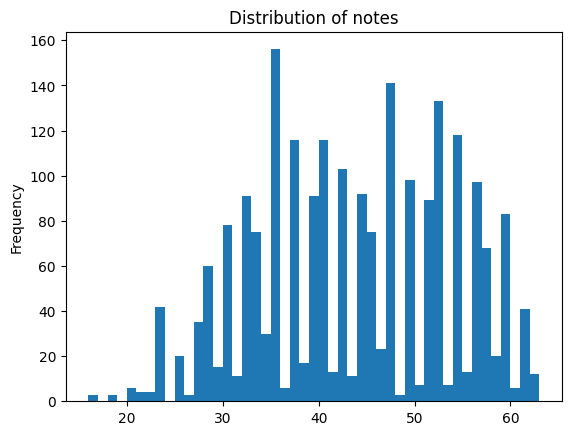

In [ ]:
notes.plot.hist(title="Distribution of notes", bins=notes.max() - notes.min());

In order to generate new samples based on a markov chain principle one can rely on the construction of a state transition matrix, which notes the probability of stepping from state $i \in \Omega$ to $j \in \Omega$, so

$$
p_{i,j} = \mathbb{P}(X_{n+1} = j | X_n = i) | i,j \in \Omega
$$

which forms a matrix of size $|\Omega|^2$.

Based on the given series of events it is possible to construct this transition matrix by counting the occurences of each "transition event".

In [ ]:
import numpy as np

NUM_NOTES = 88

transition_matrix = np.zeros((NUM_NOTES, NUM_NOTES), dtype=np.int32)

# iterate over our list of notes
for cur_note, next_note in zip(notes[:-1], notes[1:]):
    transition_matrix[cur_note, next_note] += 1

# take a look at the transitions from note 51 away
transition_matrix[51]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  1,  0,  1,  3,  0,  1,  0,  0,  1,  0,  6,  1,  4,  4,
        1, 12,  0,  3,  0,  4,  8,  0,  4,  0,  4,  1,  1,  9,  0,  3,  0,
        0,  7,  1,  5,  0,  0,  0,  0,  3,  0,  0,  0,  1,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0], dtype=int32)

In its current state, the transition matrix does not model a distribution because the probabilities do not sum up to $1$.
This can be done by scaling every row of the transition matrix by the sum of it.

In [ ]:
scaled = transition_matrix[51] / (transition_matrix[51].sum())
scaled

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.01123596, 0.        , 0.01123596, 0.03370787, 0.        ,
       0.01123596, 0.        , 0.        , 0.01123596, 0.        ,
       0.06741573, 0.01123596, 0.04494382, 0.04494382, 0.01123596,
       0.13483146, 0.        , 0.03370787, 0.        , 0.04494382,
       0.08988764, 0.        , 0.04494382, 0.        , 0.04494382,
       0.01123596, 0.01123596, 0.1011236 , 0.        , 0.03370787,
       0.        , 0.        , 0.07865169, 0.01123596, 0.05617978,
       0.        , 0.        , 0.        , 0.        , 0.03370787,
       0.        , 0.        , 0.        , 0.01123596, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

Often it is easier to estimate if the data makes sense by plotting it into a graphic representation.

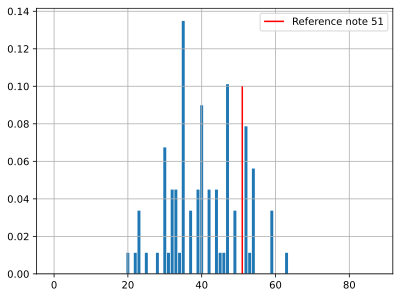

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib_inline

matplotlib_inline.backend_inline.set_matplotlib_formats("svg")

plt.bar(x=np.arange(NUM_NOTES), height=scaled)
plt.vlines(51, 0, 0.1, colors="r", label="Reference note 51")
plt.legend()
plt.grid();

Instead of taking a look at just a single note, we can create a 2 dimensional plot which tells us the number occurrences going from one note to another by attaching these two variables to the axis.
Each co-ordinate is mapped to a color which co-relates with the number of occurrences.

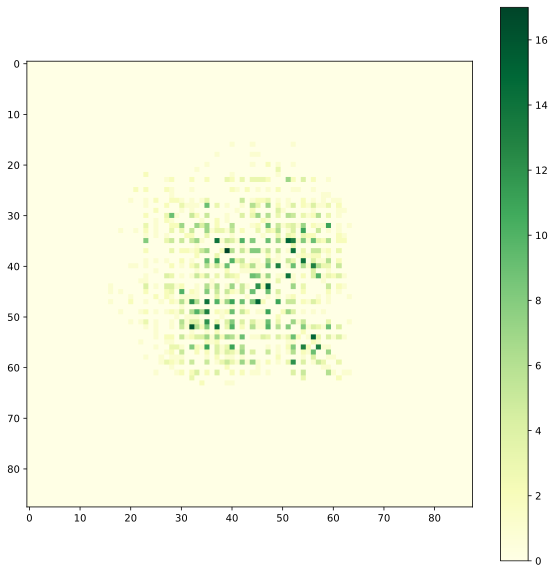

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(transition_matrix, cmap="YlGn")
plt.colorbar();

We can now use this calculated transition matrix within a markov chain to check for the next successive note by sampling the next note according to the associated probability distribution which we just generated.

In [ ]:
import numpy as np


class MarkovPiano:
    def __init__(self, transition_matrix: np.ndarray, init_state: int) -> None:
        self.transition_matrix = transition_matrix
        self.state = init_state

    def next(self) -> int:
        prob = self.transition_matrix[self.state]
        self.state = np.random.choice(len(self.transition_matrix), p=prob / prob.sum())
        return self.state

We need to provide a starting point for the markov chain to iterate through - we will set this arbitrarily to $51$.

In [ ]:
markov_piano = MarkovPiano(transition_matrix=transition_matrix, init_state=51)

for _ in range(10):
    print(markov_piano.next())

35
44
47
45
35
37
45
32
54
30


We can also playback this series via a MIDI instrument controlled via Python.

In [ ]:
import asyncio
from functools import partial
from typing import List

import mido


class MidiPlayer:
    def __init__(self, device_name: str) -> None:
        self.midi_out = mido.open_output(device_name)

    @staticmethod
    def print_devices() -> List[str]:
        return mido.get_input_names()

    def playback(self, midi_data):
        pass

    def play_message(self, message: mido.Message):
        self.midi_out.send(message)

    def play_note(self, note: int, velocity: int = 40, type="note_on", channel=0):
        self.play_message(
            mido.Message(
                type,
                note=note,
                velocity=velocity,
                channel=channel,
            )
        )

    async def async_play_note(
        self, note: int, velocity: int = 40, sustain=0.1, channel=0
    ):
        play = partial(self.play_note, note=note, velocity=velocity, channel=channel)
        play()
        await asyncio.sleep(sustain)
        play(type="note_off")

    async def async_playback(self):
        pass

    def stop_all(self):
        self.play_message(
            mido.Message(
                "control_change",
                control=120,
            )
        )

In [ ]:
# adjust this to your MIDI device
midi_player = MidiPlayer(device_name="MIDILINK-mini")

In [ ]:
for _ in range(30):
    note = markov_piano.next()
    await midi_player.async_play_note(note, sustain=0.2)

midi_player.stop_all()

This plays back the most likely note derived from out dataset, but we will soon realize that this does not capture any kind of

* rhythm
* phrasing
* velocity
* polyphony

Also, because the context provided only consists of the prior note, the system fails to comprehend concepts like a *key*, which can only be established through a larger context and not just through two successive notes.

In order to provide a larger context it is possible to increase the number of steps the markov chain takes into account, which is labeled as *n-th order markov chain*.
Yet this increases our transition matrix from a $m \times m$ matrix to a $n \times m \times m$ matrix, where $m$ is the number of possible states.

Our *state space* increases further if we take polyphony into account, and at this point it is clear that while markov chain are a very interesting mathematical objects, they do not perform well on tasks such as generalization as if the state space is too restrictive.
This is, because markov chain rely on independence of its state variables, yet music happens within a context and the articulation of a single note also correlates with the *function* of said note.

Nonetheless, Markov chains and also [Hidden Markov Models](https://en.wikipedia.org/wiki/Hidden_Markov_model) are a very powerful tool as which allow us to take a look inside and to tinker with its state.

```{admonition} Task

* Run the markov analysis on not just one but multiple files
* Try to do an additional markov chain for the timing of each note
* Implement a markov chain in SuperColider.
```